## Asymmetry and Periodicity Metrics

Last update: 19 Jan 2024

**@juliaroquette:** This notebook concentrates research-notes related to the implementation of a Python code for calculating Asymmetry and Periodicity indexes. These variability-indexes have been first introduced by [Cody+2014](https://iopscience.iop.org/article/10.1088/0004-6256/147/4/82) and are used to quantify the degree of symmetry/asymmetry and of stochasticity/periodicity in light-curves of Young Stellar Objects (YSOs). Once calculated for a given light-curve, these indexes can be used to place the star in a QM-diagram (see figure below), threshold of the two indexes can be used for classification purposes and certain regions of the diagram can be associated to physical mechanisms behind the variability processes being observed. The two indexes can also be used as feature in Machine-Learning applications. 

![QM-space](https://content.cld.iop.org/journals/1538-3881/147/4/82/revision1/aj492147f8_lr.jpg?Expires=1706211409&Signature=ANR2FKG9Mg75LFi2fPfpVfgdKx~z8PajoShKj1l2AKeQaS7K1f2u3SWXaGa4LqunH6og1RjPtGO2lkWOexBJAJEiG64j0h4wd~ixyYf4Nr8VwQk9l9DquV~T277Ff99jEl87zgYt4EXKxq3c5OINEYj99cAAlSblw63r7gNldAk9YQfN3Pb5rOvuKHUYMaksjOP4g3t5ng2UYMFf5R7-McYdvieaI03opfv0aillqBaJ1uSQUjXZGnxbci11Y32e8YdPKemi3PETyYhNtBSFesHEfMU889heezzxGduj44fxEBpEa3dt1ishRlUjaw2tdH7XTJSc2E6VBbZDxNJShw__&Key-Pair-Id=KL1D8TIY3N7T8)


**References:** 

Main previous studies applying the metrics to large samples of YSOs:
- `C14`: [Cody+2014](https://iopscience.iop.org/article/10.1088/0004-6256/147/4/82)
- `C18`: [Cody+2018](https://iopscience.iop.org/article/10.3847/1538-3881/aacead)
- `B20`: [Bredall+2020](https://doi.org/10.1093%2Fmnras%2Fstaa1588)
- `C22`: [Cody+2022](https://iopscience.iop.org/article/10.3847/1538-3881/ac5b73)
- `H22`: [Hillenbrand+2022](https://iopscience.iop.org/article/10.3847/1538-3881/ac62d8)

# Light-Curve

A light-curve is written as a series of measurements $m$ with uncertainties $\sigma$ as a function of time, $t$:

- $m_i$ and $\sigma_i$ are magnitudes and their uncertainties at the time $t_i$. 
- Alternatively the light-curve can be written in terms of fluxes $f_i$ and their uncertainties. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 100
time = np.linspace(0, 50, N)
mag = np.sin(2*np.pi*time/10.) + np.random.random_sample(N)*.5
err =  0.001*np.random.random_sample(N)

<ErrorbarContainer object of 3 artists>

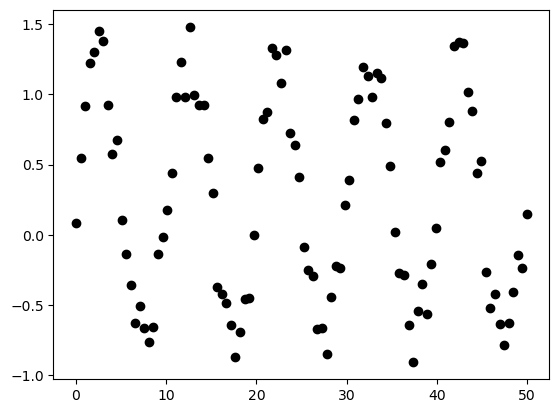

In [3]:
plt.errorbar(time, mag, err, fmt='o', color='black', capsize=3)

# Synthetic Models

In this section, we explore various synthetic models designed to mimic observed light curves. The following types of models are considered:

- **Quasi-Periodic Light Curves:** Quasi periodic refers to light curves whose amplitude is a function of time. Our model draws a random amplitude from a Gaussian distribution at each time step.

- **Multi-Periodic Light Curves:** Light curves with a primary period around 5 days, and a longer secondary period around 20 days

- **Aperiodic Dippers:** Models falling under this category exhibit aperiodic behavior, adding diversity to the synthetic light curves.


In [4]:
#Quasi periodic light curves

def quasi_per_amp(time, std, amp = 1, frequency = 1/10):
    '''
    Generates a lc with amplitude changing over time. For each time step, the amplitude is drawn from a Gaussian distribution

    Args :
        time : light curve time array
        std : std of Gaussian

    returns :
        mag
    '''

        
    random_steps     = np.random.normal(0, std, len(time))            
    amp_t            = np.cumsum(random_steps) + amp
    mag_qp           = amp_t * np.sin(2 * np.pi * frequency * (time - min(time))) + \
                       np.random.normal(0, 0.05, len(time))

    return mag_qp

<ErrorbarContainer object of 3 artists>

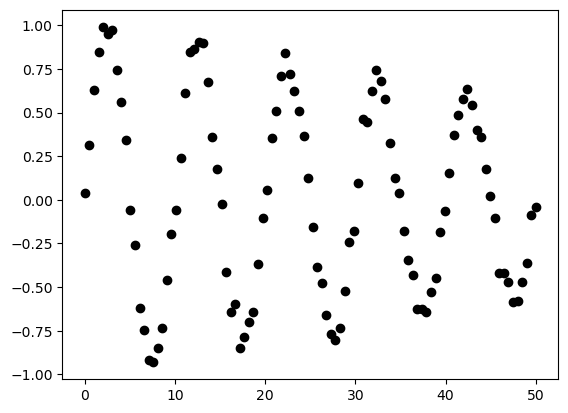

In [5]:
mag_qp = quasi_per_amp(time, 0.03)
plt.errorbar(time, mag_qp, err, fmt='o', color='black', capsize=3)

In [6]:
#Multi periodic light curves
def multiperiodic(time, frequency = 1/5, frequency_long = 1/40, amp = 1, amp2 = 0.2):
        noise             = np.random.normal(0, 0.03, len(time))
        mag_mp            = amp * np.sin(2 * np.pi * frequency * (time - min(time))) + \
                            amp2 * np.sin(2 * np.pi * frequency_long * (time - min(time))) + \
                            noise
        return mag_mp

<ErrorbarContainer object of 3 artists>

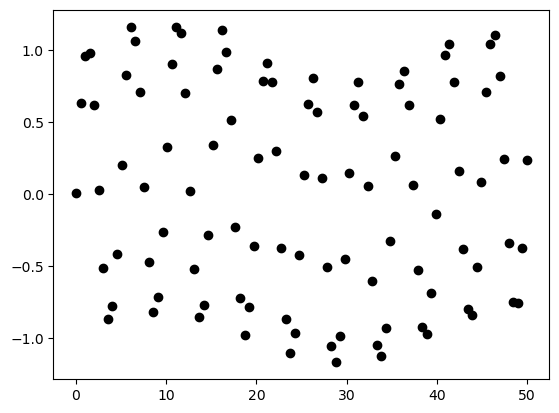

In [7]:
mag_mp = multiperiodic(time)
plt.errorbar(time, mag_mp, err, fmt='o', color='black', capsize=3)

In [8]:
#aperiodic dippers

def apd(time, num_dips, dip_depth_range, dip_width_range, amp = 1):
        """
        Generate a synthetic light curve with aperiodic dips. Amplitude of the curve is based on self.amp
        Based on a random walk.
        """
    
        rand_walk = np.cumsum(np.random.randn(len(time)))

        for _ in range(num_dips):
            dip_position = np.random.randint(0, len(time))
            dip_depth    = np.random.uniform(*dip_depth_range)
            dip_width    = np.random.uniform(*dip_width_range)

            gaussian_peak = dip_depth * np.exp(-((time - dip_position) / (dip_width / 2))**2)
            rand_walk    -= gaussian_peak

        # Normalize rand_walk to have a peak-to-peak amplitude of 1
        normalized_rand_walk = (rand_walk - np.min(rand_walk)) / (np.max(rand_walk) - np.min(rand_walk))

        # Scale with self.amp and add self.med_mag
        mag_apd = normalized_rand_walk * amp
        
        return mag_apd

<ErrorbarContainer object of 3 artists>

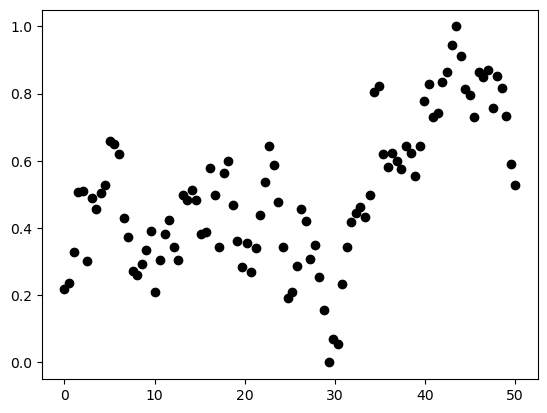

In [9]:
dips          = 3
depth_range   = (0.3, 1)
width_range   = (0.5, 2.5)

mag_apd = apd(time, dips, depth_range, width_range)
plt.errorbar(time, mag_apd, err, fmt='o', color='black', capsize=3)

# Filter the light curve

2 steps are considered :

- **Remove longtrends** : Savitzky-Golay filter with window size of 25% the lc duration
- **Remove outliers** : 5 sigma clip

In [10]:
from scipy.signal import savgol_filter

def remove_longtrend(time, mag) :
        
        ws =  int(0.25*len(mag))

        mag_filt = savgol_filter(mag, ws, 3)
        mag_filt = mag - mag_filt + np.median(mag)
        return mag_filt

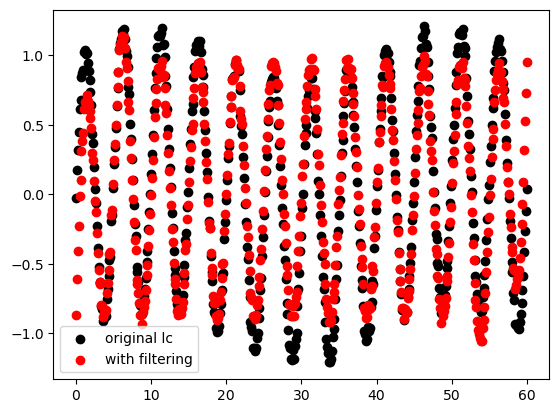

In [11]:
time2 = np.linspace(0, 60, 500)
mag_mp2 = multiperiodic(time2)

mag_filt = remove_longtrend(time2, mag_mp2)

plt.scatter(time2, mag_mp2,  color='black', label = 'original lc')
plt.scatter(time2, mag_filt, color='red',   label = 'with filtering')
plt.legend()

# M- index: Asymmetry

**Context**: Metrics that measures the level of assymetry in the light-curve.

$$M=\frac{<m_{10\%}>-m_{med}}{\sigma_m}$$

where:
- $<m_{10\%}>$ is all the data in the top and bottom decile of the light-curve. 
- $\sigma_m$ is the light-curve's standard deviation

This definition sets predominantly brightening light-curves with $M < 0$ and predominantly dimming  with $M > 0$.

When using fluxes, one must add a $-1\times$ to $M$'s definition to preserve the dimming/brightening signal definition. 

**Note on filtering**: Light-curves must be appropriately pre-filtered. See section on this subject below. 

**Literature definition variations**

- $\sigma_m$ is sometimes the overall rms (`C14`) of the light-curve and sometimes its standard-deviation (`H22`, `B20`).
- Use of deciles: `C18` reports the use of 5/95 percentiles rather than deciles. However, Ann Marie Cody told us in private communication that this might be a typo in the paper as her code `C22` is using 10/90. 

In [12]:
def M_index(mag, per_up=90., per_down=10., is_flux=False):
    """
    Calculate the M-index, which measures the level of asymmetry in the light-curve.
    
    Parameters:
    - mag: array-like, magnitudes of the light-curve
    - per_up: float, upper percentile for selecting data in the top decile
    - per_down: float, lower percentile for selecting data in the bottom decile
    - is_flux: bool, indicates whether the input is flux or magnitude
    
    Returns:
    - M-index: float, the calculated M-index value
    
    """
    if bool(is_flux):
        to_flux = -1
    else:
        to_flux = 1
    return to_flux*(np.mean(mag[(mag <= np.percentile(mag, per_down)) | (mag >= np.percentile(mag, per_up))]) - np.median(mag))/np.std(mag)

# Q-index: Periodicity

**Context**: Metrics that measures the degree of periodicity in the light-curve. 

$Q = \frac{\sigma_\mathrm{res}^2-\sigma_\mathrm{phot}^2}{\sigma^2_\mathrm{raw}-\sigma^2_\mathrm{phot}}$, 

where:
- $\sigma_\mathrm{res}^2$ and $\sigma^2_\mathrm{raw}$ are the variance values of the raw light curve and the phase-subtracted light curve.
- $\sigma_\mathrm{raw}^2$ is the variance of the original light-curve
- $\sigma_\mathrm{phot}$ is the mean photometric error

In [13]:
def Q_index(mag_phased, residual_mag, err_phased):
        """
        Calculates the Q-index which measures the level of periodicity in the light-curve.

        Parameters:
        mag_phased (array-like): Array of phase-folded magnitudes for the "raw" light-curve.
        residual_mag (array-like): Array of phase-folded residual magnitudes after waveform-subtraction
        err_phased (array-like): Array of errors for the phase-folded light-curve.

        Returns:
        - Q-index float: The calculated Q-index.

        """
        return (np.std(residual_mag)**2 - np.mean(err_phased)**2)/(np.std(mag_phased)**2 - np.mean(err_phased)**2)

Before plugging-in values in Q, a few extra steps are required:

1. Definition of $m_{raw}$: This is the original "raw" light-curve. This light-curve is called raw, but it has been already filtered for any needs deemed necessary by authors as pre-filtering before a period-search technique is applied. There is a lot of variation in what this filtering entails, hence see Filtering section below. Typical filtering will include $5-\sigma$-clipping and de-trending for variability at longer timescales than resolved by the light-curve. For high-cadence light-curves filtering may also include a short-timescale filtering that helps focusing the period-search step.
2. $\sigma_\mathrm{raw}^2$ is the variance of the light-curve in 1. 
3. $\sigma_\mathrm{phot}$ is the typical photometric error in the light-curve. In general, this is a simple average of the uncertainties in the light-curve, considering the $\sigma_i$s of all datapoints left in the filtered light-curve in step 1. However, a few studies derive a typical uncertainty value by looking at rms vs magnitude distributions for samples of less-variable stars in their survey (`C14`, `C18`, `C22`). This seems to be more common for CoRoT and K2 data though. 
4. Residual light-curve: This is the most important step for calculating Q. 

    4.1 A period-search technique is applied to $m_{raw}$ to find the dominant period, P. When no period is found, a "aperiodic timescale" must be defined instead. (see further discussion in the session below.)

    4.2 $m_{raw}$ is phase-folded to this period or timescale and some filtering is used to estimate a phase-folded waveform. (See Waveform estimation Section below)

    4.3 A residual light-curve, $m_{res}$ is defined by subtracting the waveform from the folded $m_{raw}$. A few authors do this by repeating the waveform over the length of the light-curve, but I don't think it makes a difference in the final $\sigma_\mathrm{res}$ to estimate it from the folded or from the regular light-curve. 

    4.4 $\sigma_\mathrm{res}$ is calculated from the residual light-curve ($m_{res}$)

# Waveform estimation

Once the light curve is phase folded on the period, data has to be interpolated with a waveform. Different methods can be used for this step :

- Rolling average
- Median filter
- Savitsky Golay filter

The following section shows the different waveforms that can be derived from a multiperiodic light curve. Apart from the method, the window size is also important. Usually, it is taken between 10 and 15% of the phase.

In [16]:
import pandas       as pd
from   scipy.signal import medfilt

length       = len(time)
window_sizes = [int(0.05 * length), int(0.21 * length)]

#Phase fold the light curve
period_fold = 5 #from the primary period of the multiperiodic light curve
phase       = np.mod(time, period_fold) / period_fold
sort        = np.argsort(phase)
mag_phased  = np.array(mag_mp)[sort]
phase       = phase[sort]

for it, window in enumerate(window_sizes):
    
    # rolling average
    mag_roll   = pd.Series(mag_phased).rolling(window, min_periods=window, win_type='boxcar', center=True, closed='neither').mean()
    locals()[f'mag_roll_{window}']   = mag_roll.dropna().values  # Remove NaN values

    start_idx  = (window - 1) // 2  # Assuming center=True in rolling window
    end_idx    = start_idx + len(locals()[f'mag_roll_{window}'])
    locals()[f'phase_roll_{window}'] = phase[start_idx:end_idx]
    
    
    # sav gol filter
    mag_sg = savgol_filter(mag_phased, window, 3)
    locals()[f'mag_sg_{window}'] = mag_sg[~np.isnan(mag_sg)]  # Remove NaN values

    start_idx  = 0  
    end_idx    = start_idx + len(mag_roll)
    locals()[f'phase_sg_{window}']   = phase[start_idx:end_idx]
    
    if len(locals()[f'mag_sg_{window}']) > len(locals()[f'phase_sg_{window}']) :
        mag_sg = mag_sg[0 : - (len(mag_sg) - len(phase_sg))]
        
    # medfilt
    if window % 2 == 0:
        window += 1
    mag_mf = medfilt(mag_phased, window)
    locals()[f'mag_mf_{window}'] = mag_mf[~np.isnan(mag_mf)]  # Remove NaN values
    
    end_idx    = start_idx + len(mag_mf)
    locals()[f'phase_mf_{window}']   = phase[start_idx:end_idx]
    

Text(0.5, 0, 'Phase')

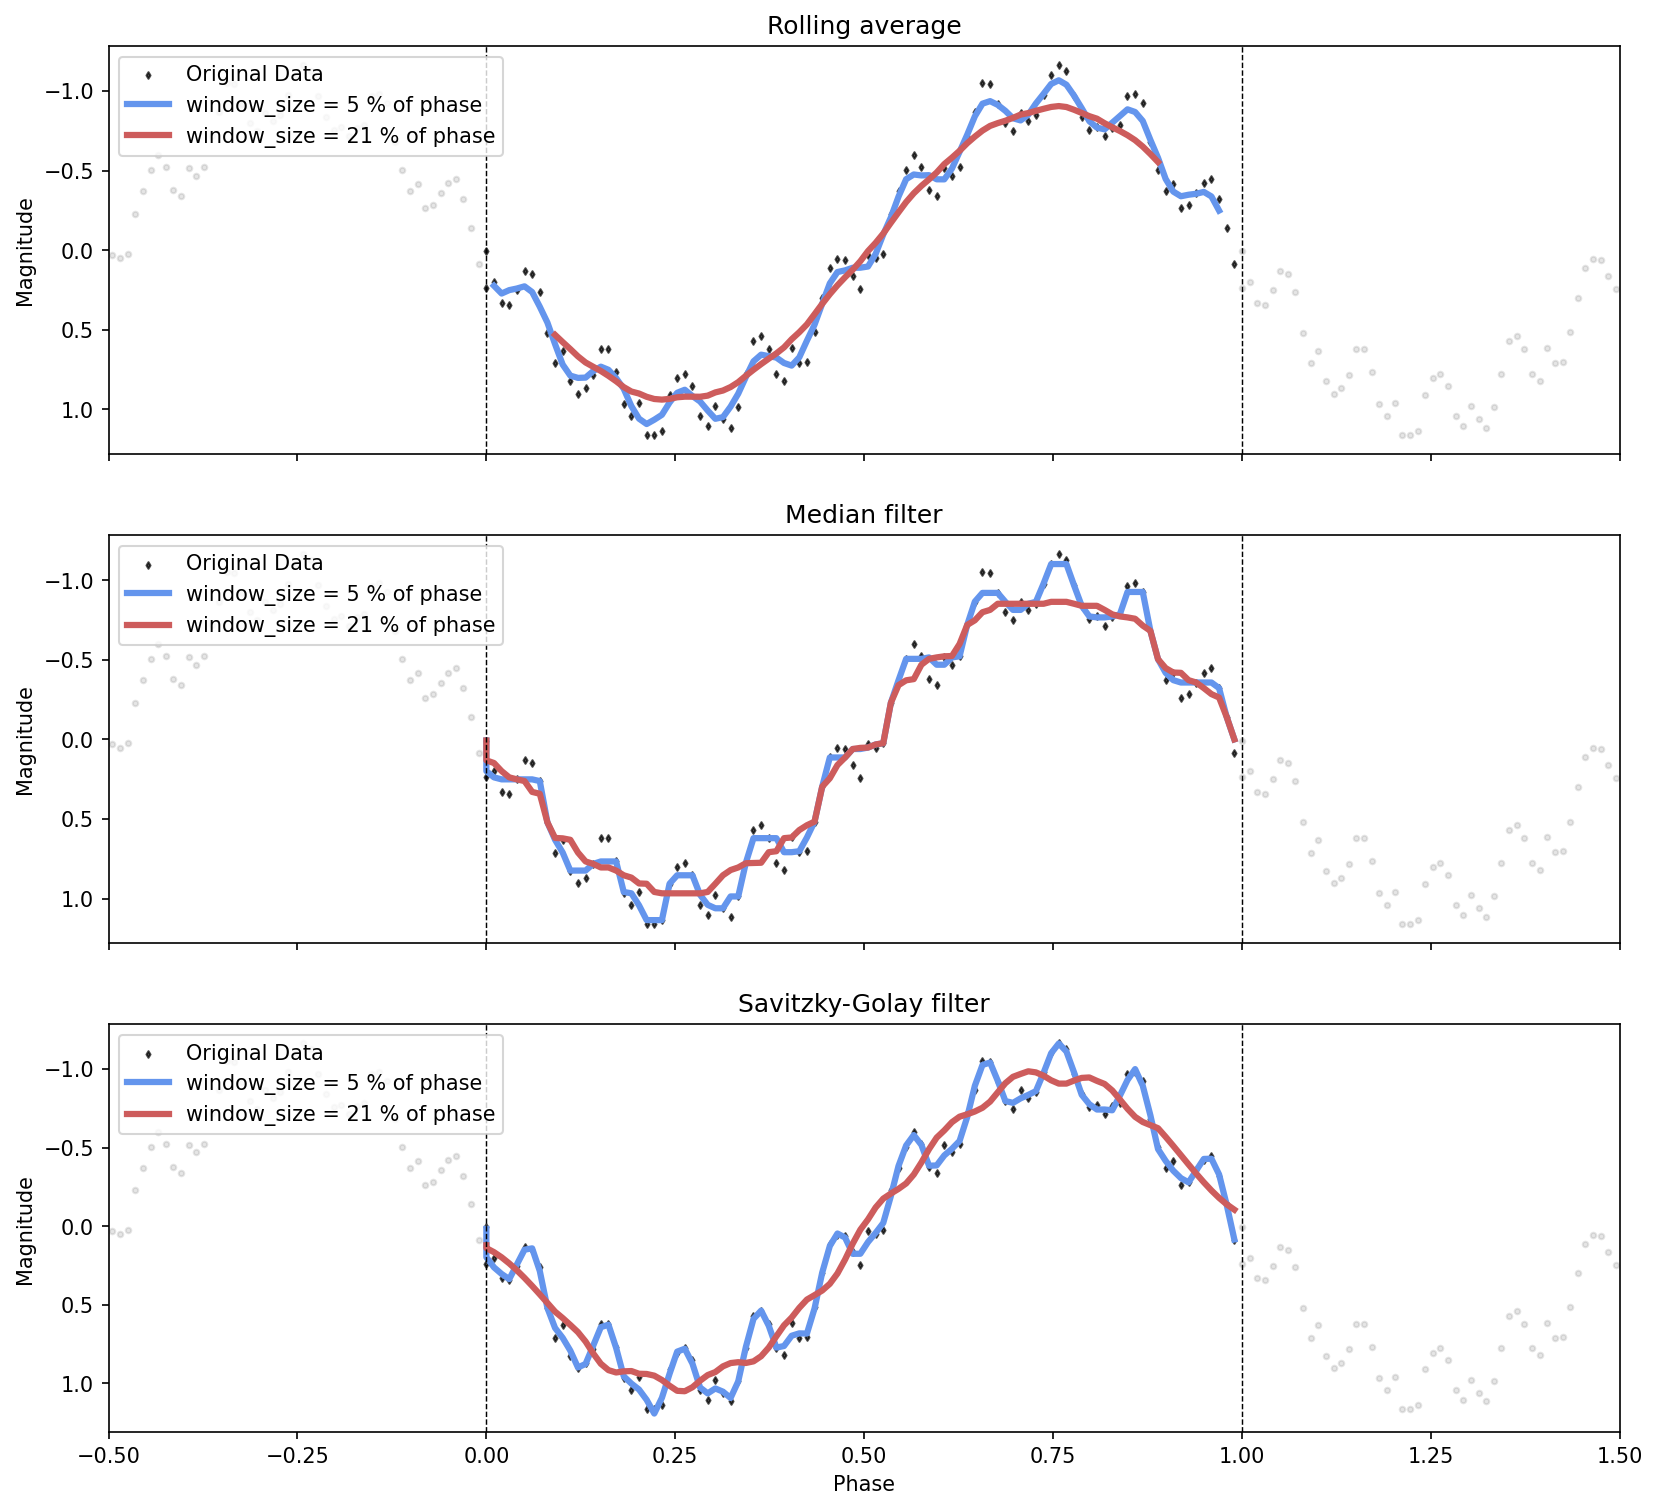

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(13, 12), facecolor='white', dpi=150, sharex=True)
size     = 5
colors = ['cornflowerblue', 'indianred']

axs[0].scatter(phase, mag_phased, label='Original Data', c='black', marker='d', s=size, alpha = .7)
axs[0].set_title('Rolling average')
axs[1].scatter(phase, mag_phased, label='Original Data', c='black', marker='d', s=size, alpha = .7)
axs[1].set_title('Median filter')
axs[2].scatter(phase, mag_phased, label='Original Data', c='black', marker='d', s=size, alpha = .7)
axs[2].set_title('Savitzky-Golay filter')

length       = len(mag_phased)

for it, window in enumerate(window_sizes):
    mag_roll   = locals()[f'mag_roll_{window}']
    phase_roll = locals()[f'phase_roll_{window}']
    mag_mf     = locals()[f'mag_mf_{window}']
    phase_mf   = locals()[f'phase_mf_{window}']
    mag_sg     = locals()[f'mag_sg_{window}']
    phase_sg   = locals()[f'phase_sg_{window}']
    
    # Plot rolling average
    axs[0].plot(phase_roll, mag_roll, label=f'window_size = {int(100*window/length)} % of phase', color=colors[it], lw = 3)

    # Plot Median Filter
    axs[1].plot(phase_mf, mag_mf, label=f'window_size = {int(100*window/length)} % of phase', color=colors[it], lw = 3)

    # Plot Savitzky-Golay Filter
    axs[2].plot(phase_sg, mag_sg, label=f'window_size = {int(100*window/length)} % of phase', color=colors[it], lw = 3)

    
for ax in axs:
    ax.scatter(phase - 1, mag_phased, c='grey', s=7, alpha=0.2)
    ax.scatter(phase + 1, mag_phased, c='grey', s=7, alpha=0.2)
    ax.axvline(0, c = 'black', ls = '--', lw = .7)
    ax.axvline(1, c = 'black', ls = '--', lw = .7)
    ax.set_xlim(-0.5, 1.5)
    ax.invert_yaxis()
    ax.set_ylabel('Magnitude')
    ax.legend(loc='upper left')

# Set common x-axis label
axs[-1].set_xlabel('Phase')